In [1]:
#For Data Manipulation
import numpy as np
import pandas as pd
from datetime import datetime

#For Getting Stocks Data 
import pandas_datareader

#For Visualizing the plots
import matplotlib.pyplot as plt

#For Interactive Controls
import ipywidgets as widgets

%matplotlib inline

In [2]:
#List of Billionaire Favorite Stocks
#LIST = ['JILL','ELTK','ONVO','UAVS','AEY','OBLN','XRF','MLSS','MICT','SOLY','NMRD','ZFGN','INUV','VTGN','RBZ','BURG','MTSL','DXR','QADA','MYOV','BOSC','APTO','PESI','TITN','EYEG','CAPR','UROV','APDN','TTPH','ECOR','WYND','ZN','OSN','HDSN','BDR','TBLT','PLM','DMRC','MOV','PVH','TLYS','CPAH','VLRX','SDRL','RWLK','VEEV','OPRX','RAVE','PFSW','SPWH','TMDX','DOOO','TC','NBY','WSTL','KEYS','DBI','INAP','RVLT','JASN','CNET','RVLV','REKR','SUMR','MBOT','BDGE','FOLD','SRRA','IDN','PIXY','LYL','MHLD','NIO','SLS','NNVC','MYT','BYND','CREG','ATIS','TCCO','AAMC','OXBR','ANCN','BCRX','ALRN','RTW','LTBR','WWR','CTRC','VTVT','MACK','NDRA','OTLK','MYT','BYND','CREG','ATIS','TCCO','AAMC','OXBR','ANCN','BCRX','ALRN','RTW','LTBR','WWR','HTHT','CTRC','MACK']
LIST = ['PG']
List = sorted(list(set(LIST)))
print(List)


returns_port = pd.DataFrame()

# Downloading the Stocks Adj Close Price from Yahoo and saving as dataframe
for i in List:
    one_stock = pandas_datareader.DataReader(i,'yahoo',datetime(2019,6,28),datetime(2019,8,31))
    #Calculating the Returns of the stock
    returns_one_stock = pd.DataFrame(np.diff(np.log(one_stock['Adj Close'].values)))
    returns_port = pd.concat([returns_port, returns_one_stock], axis=1)
returns_port.columns = List
returns_port.head()

['PG']


,PG
0,0.007631
1,0.008920
2,0.023055
3,-0.008186
4,0.007923


In [3]:
portfolios = np.mat(returns_port)

FAMA_FRENCH = pd.read_csv('D:/Downloads/F-F_Research_Data_Factors_daily.csv')

symd = 20190628
eymd = 20190830

FAMA = FAMA_FRENCH.iloc[24515:24559,1:5].copy()
print(FAMA)

MKT = pd.DataFrame(FAMA['Mkt-RF'] -  FAMA['RF'])
SMB = pd.DataFrame(FAMA['SMB'])
HML = pd.DataFrame(FAMA['HML'])

MKT.reset_index(drop=True,inplace=True)
SMB.reset_index(drop=True,inplace=True)
HML.reset_index(drop=True,inplace=True)

[T,N] = portfolios.shape

m=np.ones((T,1))

F = np.concatenate((m,MKT,SMB,HML),axis=1)

factors = np.mat(F)

K = F.shape[1]

beta = np.mat(np.zeros((K,N)))
#eta = np.mat(np.zeros((K,N)))

# Step 1 Running Times Series Regression

for j in range(portfolios.shape[1]):
    x = factors
    y = portfolios[:,[j]]
    beta[:,[j]] = np.matmul(np.matmul(np.linalg.inv(np.matmul(x.T,x)),x.T),y) 
    
beta

       Mkt-RF   SMB   HML     RF
24515    0.75 -0.54 -0.18  0.009
24516    0.14 -0.81 -0.79  0.009
24517    0.78 -0.07 -0.31  0.009
24518   -0.10  0.17  0.89  0.009
24519   -0.58 -0.44  0.03  0.009
24520    0.18 -0.15 -0.53  0.009
24521    0.40 -0.16 -0.39  0.009
24522    0.19 -0.80  0.03  0.009
24523    0.53  0.19  0.44  0.009
24524   -0.04 -0.38 -0.99  0.009
24525   -0.32  0.33  0.15  0.009
24526   -0.64 -0.14 -0.68  0.009
24527    0.35 -0.32 -0.03  0.009
24528   -0.56  0.14  0.89  0.009
24529    0.25 -0.43 -0.50  0.009
24530    0.65 -0.21  0.82  0.009
24531    0.66  0.75  0.83  0.009
24532   -0.63 -0.70 -0.21  0.009
24533    0.82  0.39 -0.21  0.009
24534   -0.32 -0.33 -0.46  0.009
24535   -0.17  1.31  0.85  0.009
24536   -1.09  0.15  0.53  0.009
24537   -1.04 -0.47 -1.94  0.007
24538   -0.87 -0.31  0.04  0.007
24539   -3.07 -0.02 -0.02  0.007
24540    1.29 -0.43 -0.56  0.007
24541    0.07  0.06 -0.87  0.007
24542    1.97  0.08 -0.29  0.007
24543   -0.78 -0.38 -0.37  0.007
24544   -1

matrix([[ 0.00242028],
        [ 0.00717059],
        [ 0.00432929],
        [-0.00443424]])

In [5]:
y_hat = np.matmul(x,beta)
print(y_hat)
residuals = y - y_hat
sigma2 = (1/T)*(np.matmul(residuals.T,residuals))
print(sigma2)
sig = np.sqrt(sigma2)
print(sig)
varcov_beta_hat

[[9.56803597e-05]]
[[1.29064483e-06]]
[[0.00113607]]


In [4]:
#Step 2. RUN CROSS-SECTIONAL REGRESSION
# ACTIVE RETURNS
lamb = np.zeros((K,T))
alpha = np.zeros((N,T))
sigma = np.zeros((T,N,N))

for i in range(portfolios.shape[0]):
    x = beta.T
    y = portfolios[[i],:].T
    lambdafun = np.matmul(np.matmul(np.linalg.inv(np.matmul(x.T,x)),x.T),y)
    lamb[:,[i]] = lambdafun
    alpha[:,[i]] = np.subtract(y,np.matmul(x,lambdafun))
    sigma[[i],:,:] = np.matmul(alpha[:,[i]],alpha[:,[i]].T)

ALPHA = alpha.mean(axis =1)
SIGMA = sigma.mean(axis =0)

LinAlgError: Singular matrix

c:\python\lib\site-packages\ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


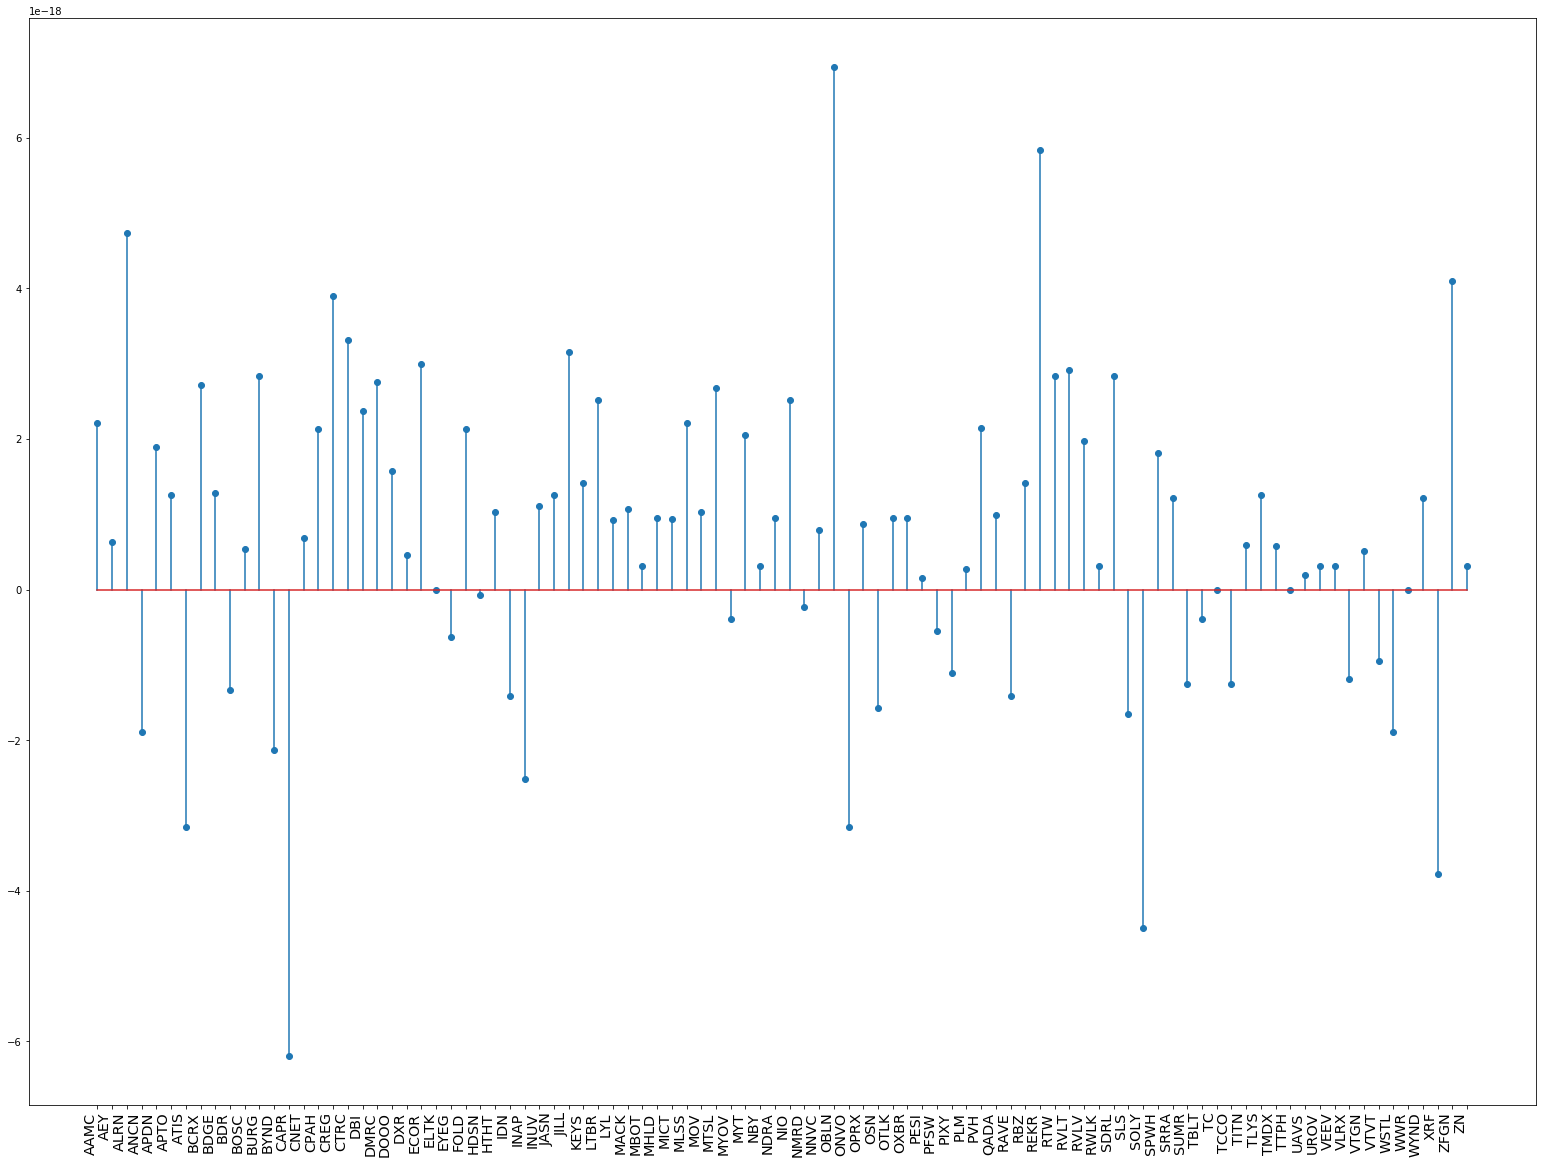

In [9]:
#Visualizing the active returns 

x = pd.DataFrame(ALPHA,columns=['Values'])
x['Stock'] = List
plt.rcParams["figure.figsize"] = (27,20)
plt.stem(x['Stock'] , x['Values'])
plt.xticks(
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'
)
plt.show()

Alpha Size :  (94, 44)


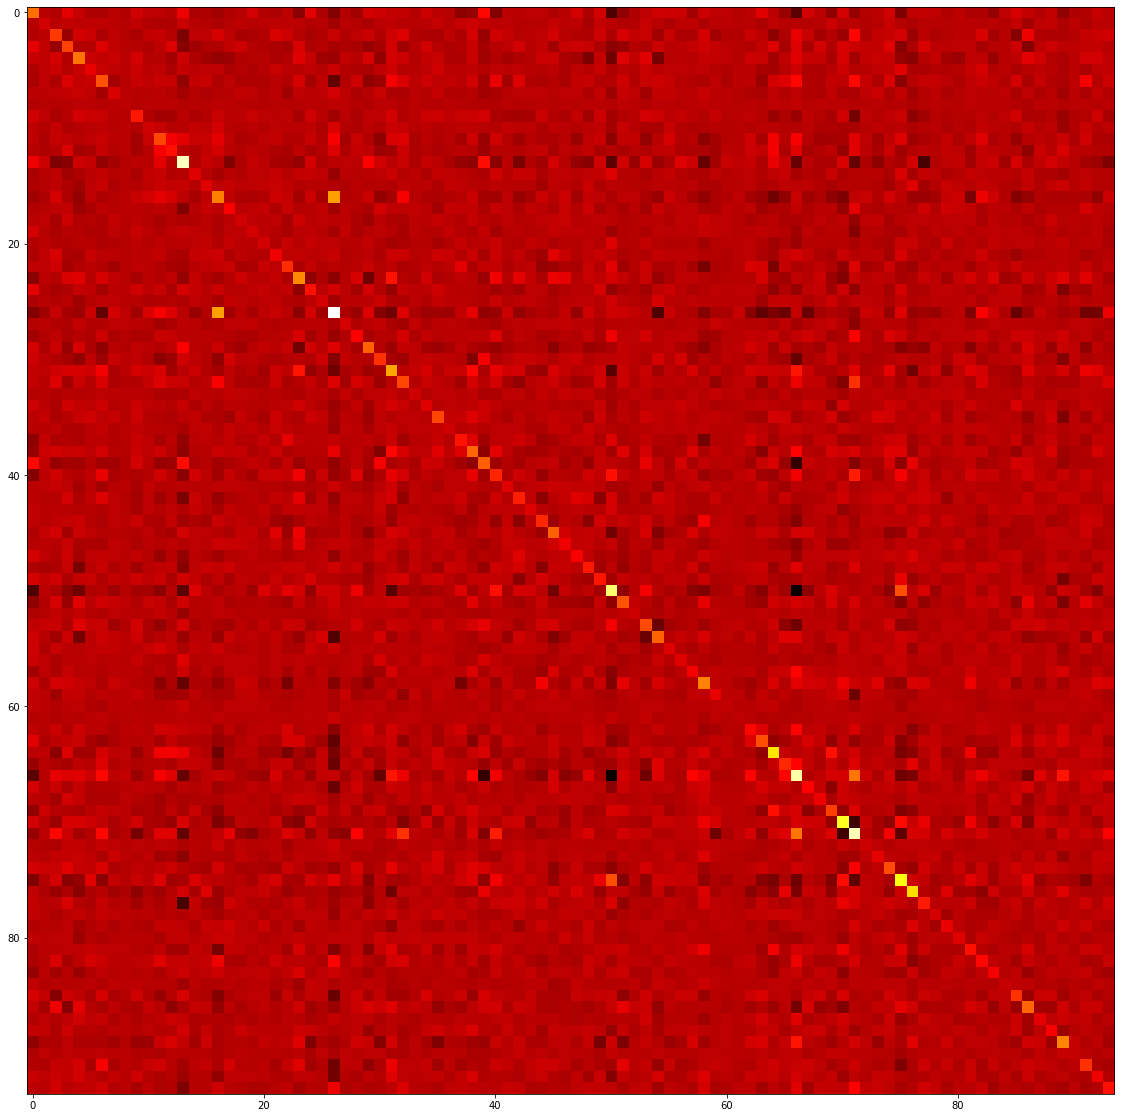

In [10]:
plt.imshow(SIGMA,cmap = 'hot')
#for i in range(95):
#    print(SIGMA[i,0])
print('Alpha Size : ',alpha.shape)

In [12]:
#calculating wieghts using MVP :

R = ALPHA
R = np.reshape(R,(94,1))
I = np.ones((N,1))
V = SIGMA
V_inv = np.linalg.inv(V)

a = float(np.matmul(np.matmul(R.T,V_inv),R))
b = float(np.matmul(np.matmul(R.T,V_inv),I))
c = float(np.matmul(np.matmul(I.T,V_inv),I))

A = np.matrix([[a,b],[b,c]],dtype = 'float')
A_inv = np.linalg.inv(A)

r_star = (b/c)

lamda_halfs = np.matmul(A_inv,([[r_star],[1]]))


In [13]:
float(lamda_halfs[1])

-8.679852726479004e-21

In [14]:
#R.shape
x = float(lamda_halfs[0])*np.matmul(V_inv,R) + float(lamda_halfs[1])*np.matmul(V_inv,I)
print(sum(x))
print(x)

[1.]
[[ 0.01211416]
 [ 0.02621244]
 [-0.04258802]
 [-0.12823753]
 [-0.10694996]
 [ 0.19652622]
 [-0.07435174]
 [-0.10395113]
 [-0.47986084]
 [ 0.10104242]
 [-0.04290747]
 [-0.02085419]
 [ 0.23671181]
 [-0.02340722]
 [ 0.40709065]
 [ 0.12240677]
 [ 0.10692618]
 [-0.10540947]
 [ 0.06495261]
 [ 0.050297  ]
 [ 0.03634665]
 [-0.24686935]
 [ 0.21372782]
 [-0.16421946]
 [-0.46217336]
 [ 0.11325671]
 [ 0.02339765]
 [-0.23329218]
 [-0.02494067]
 [-0.0844313 ]
 [ 0.15246335]
 [-0.02076661]
 [ 0.05614387]
 [ 0.2521311 ]
 [ 0.17150364]
 [ 0.0203057 ]
 [-0.42900423]
 [-0.18511302]
 [-0.10452117]
 [-0.3013858 ]
 [ 0.07014723]
 [-0.35410605]
 [ 0.07313196]
 [-0.36875619]
 [ 0.08854004]
 [-0.02582658]
 [ 0.18280475]
 [-0.0908353 ]
 [-0.00430161]
 [ 0.17295596]
 [-0.03834048]
 [-0.08002759]
 [-0.10734699]
 [-0.09786697]
 [-0.02420209]
 [ 0.02969522]
 [ 0.31541688]
 [ 0.01658082]
 [ 0.02996593]
 [ 0.08605828]
 [ 0.85800005]
 [ 0.90412074]
 [ 0.09891146]
 [-0.12327621]
 [-0.01840958]
 [ 0.05756376]
 [-0.

In [15]:
variance_of_portfolio = np.matmul(np.matmul(x.T,V),x)

variance_check = 8.67361738e-19*r_star + 3.43072332e-20
print(variance_check)
print(variance_of_portfolio)

3.430723320000001e-20
[[2.12192944e-19]]


     Weights Stocks      Risk
61  0.904121   QADA  0.011582
60  0.858000    PVH  0.015636
88  0.429743   WSTL  0.039708
14  0.407091   CNET  0.031196
56  0.315417   PESI  0.031535
67  0.270314   RVLV  0.041579
33  0.252131   KEYS  0.023945
86  0.247085   VTGN  0.065295
77  0.245842   TCCO  0.048697
12  0.236712   BYND  0.046218


c:\python\lib\site-packages\ipykernel_launcher.py:12: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  if sys.path[0] == '':


<StemContainer object of 3 artists>

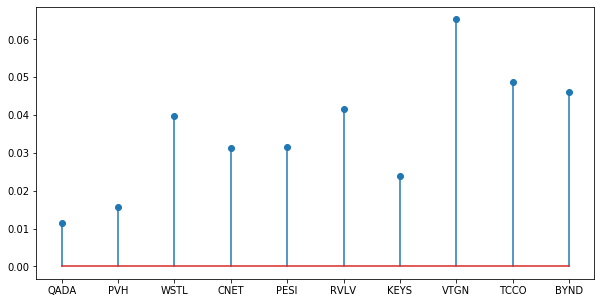

In [16]:
active_rate = pd.DataFrame( list(x),columns=['Weights'])
active_rate['Stocks'] = List
active_rate['Risk'] = np.sqrt(list(np.diag(SIGMA)))
top10_active = active_rate.nlargest(10,'Weights')


#plt.rcParams["figure.figsize"] = (15,15)
#plt.stem(active_rate['Stocks'] , active_rate['Risk'])

print(top10_active)
plt.rcParams["figure.figsize"] = (10,5)
plt.stem(top10_active['Stocks'] , top10_active['Risk'])


In [17]:
# Extra Code

lamb1 = (lamb.T - lamb.mean(axis = 1))
sum(np.matmul(lamb1,lamb1.T))/(T**2)

array([-1.00355904e-18,  1.64870413e-19,  6.88154767e-19, -4.30096730e-19,
       -2.52323415e-18,  4.58769845e-19, -1.60569446e-18, -5.73462306e-19,
        1.03223215e-18, -5.73462306e-20, -1.14692461e-19,  1.72038692e-18,
       -1.83507938e-18, -8.02847229e-19, -1.03223215e-18, -1.26161707e-18,
       -4.58769845e-19,  5.51957470e-19,  3.15404268e-19, -6.88154767e-19,
       -8.88866574e-19, -6.66649931e-19,  8.02847229e-19, -1.43365577e-18,
       -4.58769845e-19, -2.29384922e-19,  4.01423614e-19, -1.43365577e-18,
       -1.14692461e-19, -2.17915676e-18, -7.16827883e-19,  3.21138891e-18,
        2.00711807e-19, -6.59481652e-19,  1.60569446e-18,  3.72750499e-19,
       -5.01779518e-19, -5.73462306e-20, -1.20427084e-18,  4.58769845e-19,
        0.00000000e+00, -9.17539690e-19,  1.14692461e-18,  4.58769845e-19])

In [19]:
# Extra Code

lamb
one_stock = pandas_datareader.DataReader('PG','yahoo',datetime(2019,6,28),datetime(2019,8,31))
print(len(one_stock))
print(one_stock)
returns_one_stock1 = pd.DataFrame(np.log(one_stock['Adj Close'].values))
print(len(returns_one_stock1))
returns_one_stock = pd.DataFrame(np.diff(np.log(one_stock['Adj Close'].values)))
print(len(returns_one_stock))

45
                  High         Low        Open       Close      Volume  \
Date                                                                     
2019-06-28  111.959999  109.019997  111.860001  109.650002  12152000.0   
2019-07-01  110.699997  109.610001  109.919998  110.489998   6775900.0   
2019-07-02  111.500000  110.290001  110.610001  111.480003   6578200.0   
2019-07-03  114.269997  111.839996  111.959999  114.080002   6223300.0   
2019-07-05  113.449997  112.230003  112.970001  113.150002   8694800.0   
2019-07-08  114.230003  113.300003  113.339996  114.050003   5317800.0   
2019-07-09  113.910004  112.320000  113.900002  112.910004   7537700.0   
2019-07-10  114.500000  113.400002  113.459999  113.750000   5600700.0   
2019-07-11  114.400002  113.440002  113.660004  114.379997   4625300.0   
2019-07-12  115.209999  114.070000  114.070000  114.989998   7058600.0   
2019-07-15  115.879997  114.790001  115.070000  115.480003   6240700.0   
2019-07-16  116.519997  115.449997 